In [1]:
import numpy as np 
import pandas as pd

import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import TextBlob

import seaborn as sns
import matplotlib.style as style 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
# from sklearn.preproccessing import LabelEncoder
set_config(display="diagram")
import time
from better_profanity import profanity




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohandodda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("../data/train-balanced-sarcasm.csv")


In [5]:
df['comment'] = df['comment'].dropna(axis=0)
df_sampled  = df


In [9]:
def count_character_type(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            specialChar+=1
        
    return specialChar

# excl_count_sarcasm = count_character_type(df_sarcasm_text)
# excl_count_non = count_character_type(df_non_sarcasm_text)


df_sampled['explanation marks'] = (df_sampled['parent_comment'].astype(str)+" "+df_sampled['comment'].astype(str)).apply(lambda x: count_character_type(x))

# print(f"Count of exclamation marks for sarcastic comments: {excl_count_sarcasm}")
# print(f"Count of exclamation marks for non sarcastic comments: {excl_count_non}")

In [10]:
def count_question_mark(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "?":
            specialChar+=1
        
    return specialChar

# qnmark_count_sarcasm = count_question_mark(df_sarcasm_text)
# qnmark_count_non = count_question_mark(df_non_sarcasm_text)

df_sampled['count_question_mark'] = (df_sampled['parent_comment'].astype(str)+" "+df_sampled['comment'].astype(str)).apply(lambda x: count_question_mark(x))


# print(f"Count of question marks for sarcastic comments: {qnmark_count_sarcasm}")
# print(f"Count of question marks for non sarcastic comments: {qnmark_count_non}")

In [11]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# df_sarcasm['Subjectivity'] = df_sarcasm['comment'].astype(str).apply(get_subjectivity)
# df_non_sarcasm['Subjectivity'] = df_non_sarcasm['comment'].astype(str).apply(get_subjectivity)
df_sampled['Subjectivity'] = (df_sampled['parent_comment'].astype(str)+" "+df_sampled['comment'].astype(str)).astype(str).apply(get_subjectivity)

# print(f"Subjectivity score for sarcastic comments:{df_sarcasm['Subjectivity'].sum()}")
# print(f"Subjectivity score for for non sarcastic comments: {df_non_sarcasm['Subjectivity'].sum()}")

In [12]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# df_sarcasm['Subjectivity'] = df_sarcasm['comment'].astype(str).apply(get_subjectivity)
# df_non_sarcasm['Subjectivity'] = df_non_sarcasm['comment'].astype(str).apply(get_subjectivity)
df_sampled['Sentiment'] = (df_sampled['parent_comment'].astype(str)+" "+df_sampled['comment'].astype(str)).astype(str).apply(get_sentiment)


In [16]:
df_sampled = df.sample(100000, replace=False, random_state=1)


In [17]:
def count_profane_words(text):
#     count = 0
#     for sent in text.split():
    if profanity.contains_profanity(text) == True:
        return 1
    else:
        return 0
#             count = count+1
    return count
df_sampled['count_profane_words'] = (df_sampled['parent_comment'].astype(str)+" "+df_sampled['comment'].astype(str)).apply(lambda x: count_profane_words(x))

# print(f"Count of profane words in sarcastic comments: {count_profane_words(df_sarcasm_text)}")
# print(f"Count of profane words in non sarcastic comments: {count_profane_words(df_non_sarcasm_text)}")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_sampled['subreddit_labels'] = le.fit_transform(df_sampled['subreddit'])

from sklearn.preprocessing import LabelEncoder
lea = LabelEncoder()
df_sampled['author_labels'] = le.fit_transform(df_sampled['author'])



In [ ]:
emb = np.load('/Users/mohandodda/classes/cs6471/CASCADE/users/user_embeddings/user_gcca_embeddings.npz', )

In [ ]:
df_sampled['special_characters'] = df_sampled['count_question_mark'] + df_sampled['explanation marks']

In [ ]:
# emb['ids'][4].decode('UTF-8')[1:-1] in df['author']
emb = np.load('/Users/mohandodda/classes/cs6471/CASCADE/users/user_embeddings/user_gcca_embeddings.npz' )
l = []
for val in emb['ids']:
    l.append(val.decode('UTF-8')[1:-1])
# commentauthors = [comments[key]['author'] for key in comments]
# commentauthorsunique = np.unique(np.array(list(filter(lambda v: v==v, commentauthors))).astype(str))

In [ ]:
userincommon = list(set(l) & set(set(df_sampled['author'])))
df_sampled.index = df_sampled['author']
uniquedf_sampled = df_sampled.loc[userincommon]
# set(df['author'])
embdic = {v: k for k, v in enumerate(l)}
userindexes = []

for val in uniquedf_sampled.iterrows():
    userindexes.append(embdic[val[0]])
uniquedf_sampled['userindexes'] = userindexes
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
twodimG = pca.fit_transform(emb['G'])
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
onedimG = pca.fit_transform(emb['G'])
uniquedf_sampled['User Personality/Style'] = onedimG[userindexes]

In [ ]:
# uniquedf_sampled['User personality/style 1'] = twodimG[userindexes][:, 0]
# uniquedf_sampled['User personality/style 2'] = twodimG[userindexes][:, 1]

uniquedf_sampled['User Personality/Style'] = onedimG[userindexes]


In [ ]:
uniquedf_sampled['Subreddit'] = uniquedf_sampled['subreddit_labels']
uniquedf_sampled['User'] = uniquedf_sampled['author_labels']

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(uniquedf_sampled[['Subreddit', 'Subjectivity', 'special_characters', 'Sentiment', 'count_profane_words', 'User', 'User Personality/Style' 
#                                                                    'User personality/style 1', 'User personality/style 2'
                                                                  ]],uniquedf_sampled['label'],random_state=42)


In [14]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

l = XGBClassifier()
l.fit(X_train,Y_train)
preds = l.predict(X_test)
print(accuracy_score(Y_test, preds))

/opt/homebrew/Caskroom/miniforge/base/envs/cascade/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


NameError: name 'X_train' is not defined

<Figure size 2880x1440 with 0 Axes>

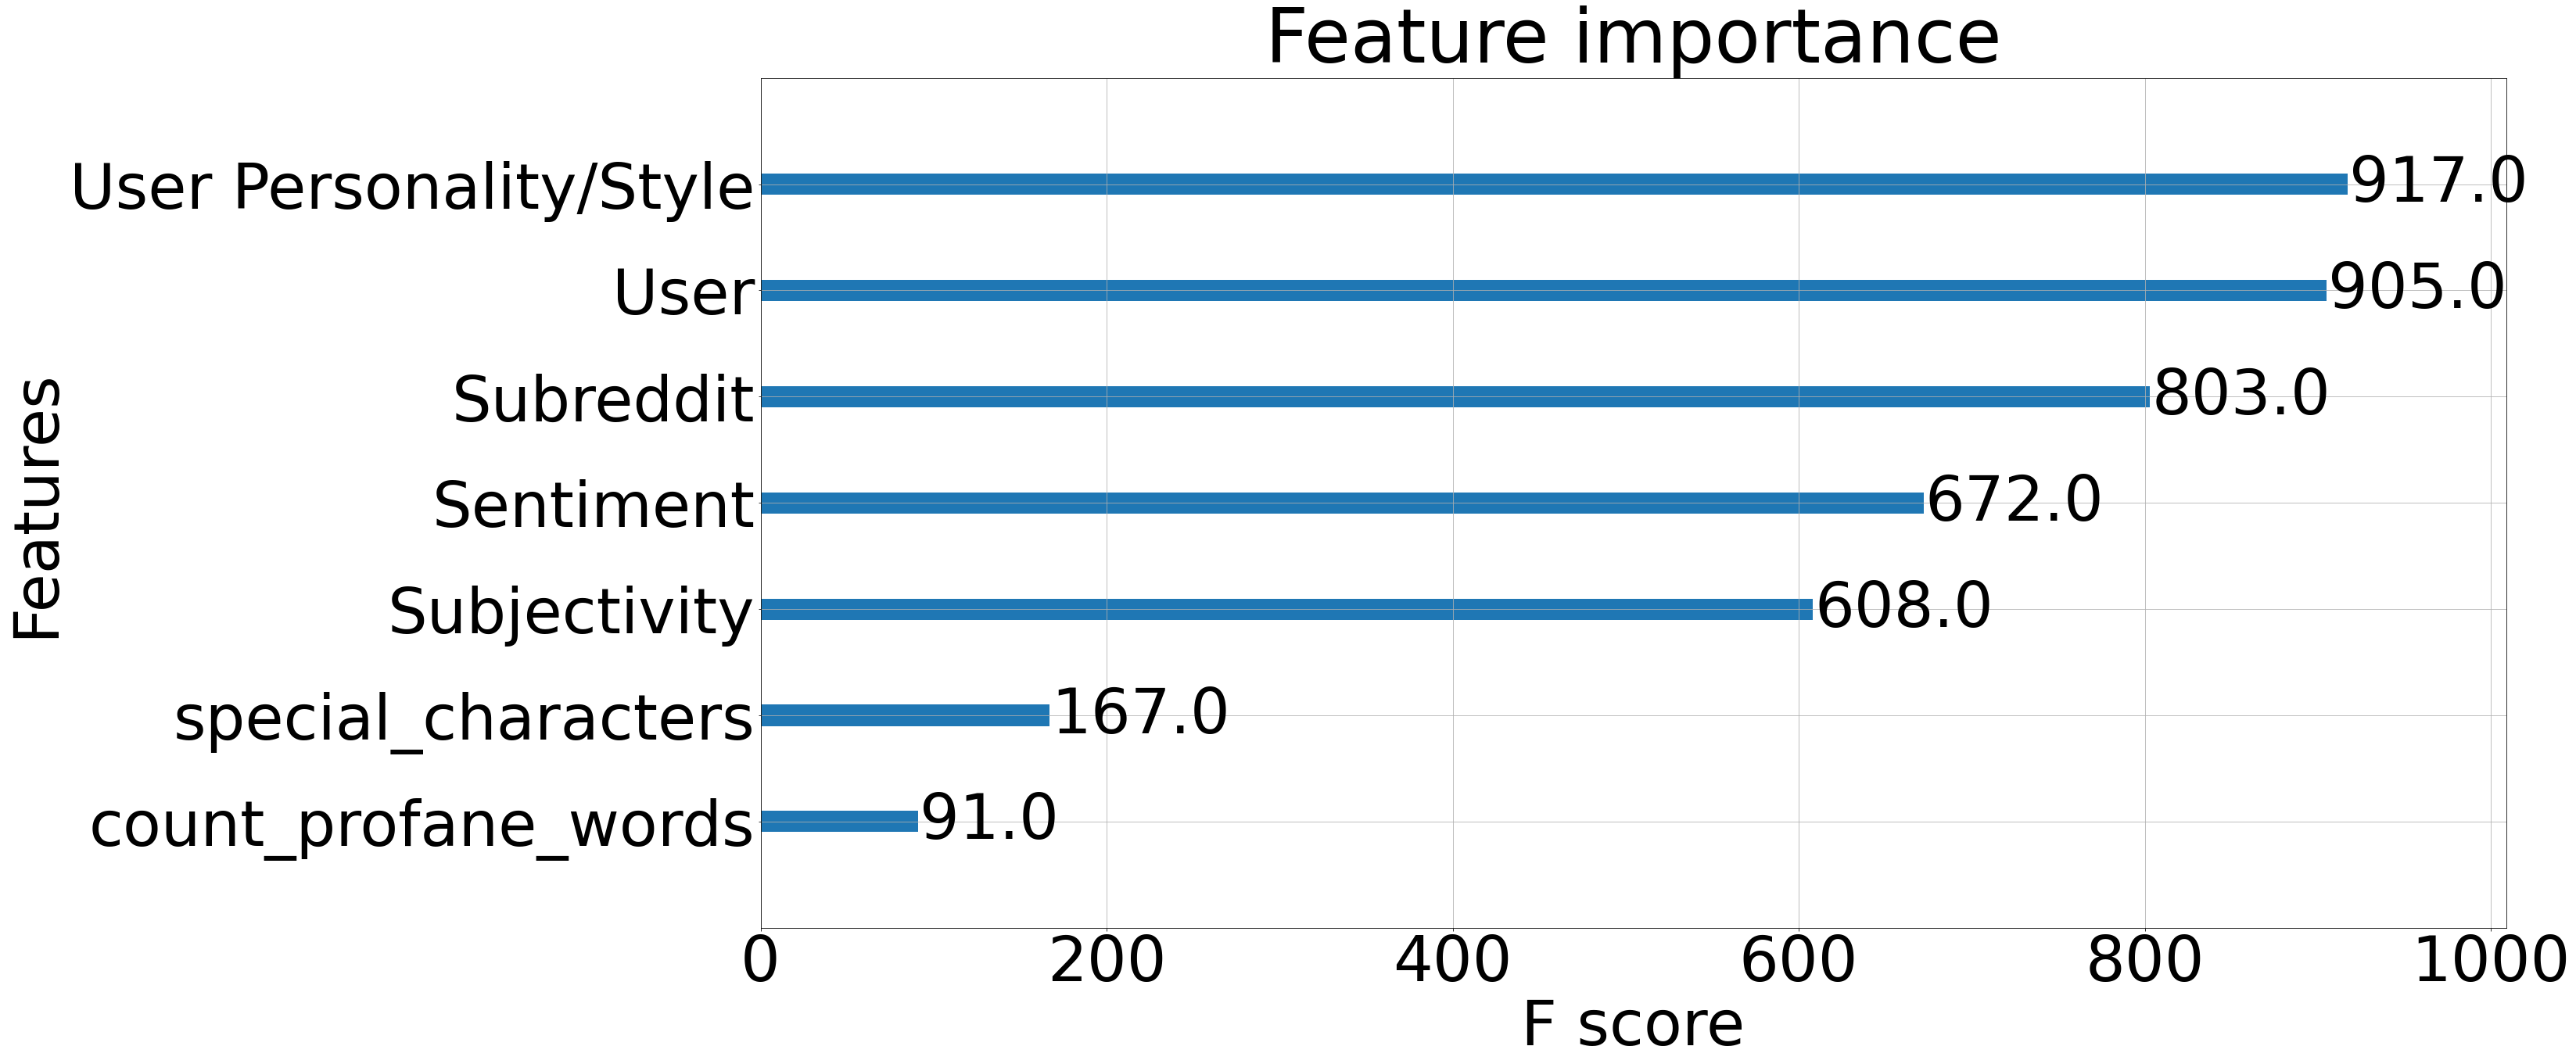

In [41]:
import xgboost
plt.figure(figsize=(40,20))
# plt.xlabel('F score', fontsize=30)
# plt.ylabel('Features', fontsize=30)
xgboost.plot_importance(l)

plt.rcParams["figure.figsize"] = (40,20)
plt.rcParams["font.size"] = 30

plt.show()
